In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import nltk

In [34]:
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv');
df = df.head(500)

In [35]:
df["Text"].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

## QUICK EDA

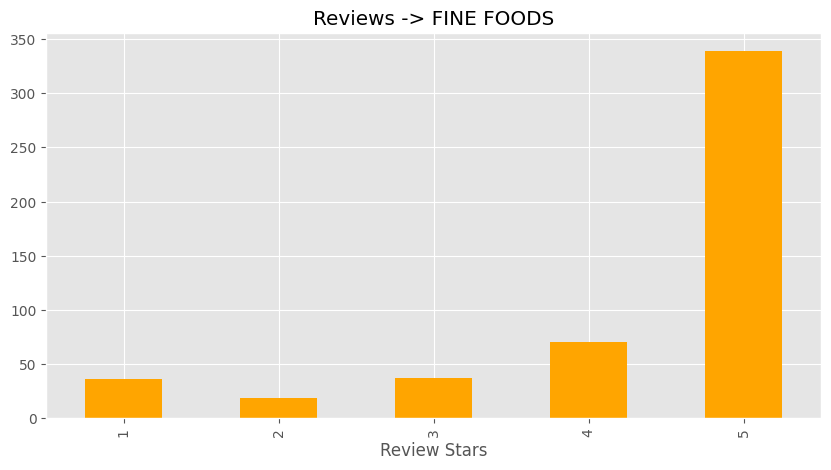

In [36]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', 
                                                  title='Reviews -> FINE FOODS',
                                                  figsize=(10,5),
                                                  color='orange')
ax.set_xlabel('Review Stars')
plt.show()

In [37]:
example = df["Text"].values[50]
print(example)


This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [38]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [39]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [40]:
entities =nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Vader Sentiment Scoring

In [41]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [42]:
res = {}

for index,row in tqdm(df.iterrows(), total=len(df)):
    r_id = row["Id"]
    review = row["Text"]
    res[r_id] = sia.polarity_scores(review)

  0%|          | 0/500 [00:00<?, ?it/s]

In [43]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index(names=["Id"])
vaders = vaders.merge(df, how='left')
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Run polarity scores on the entire dataset

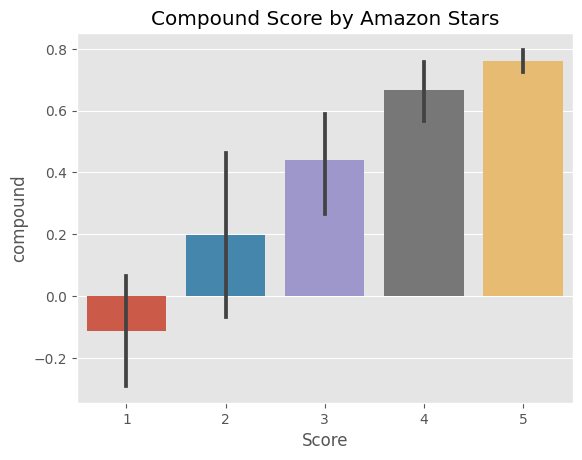

In [44]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title("Compound Score by Amazon Stars")
plt.show()

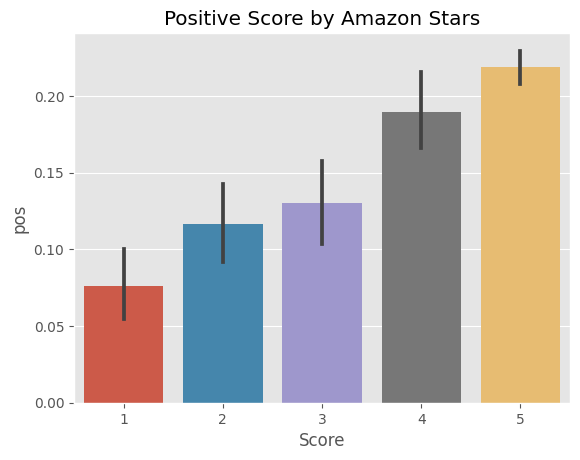

In [45]:
ax = sns.barplot(data=vaders, x='Score', y='pos')
ax.set_title("Positive Score by Amazon Stars")
plt.show()

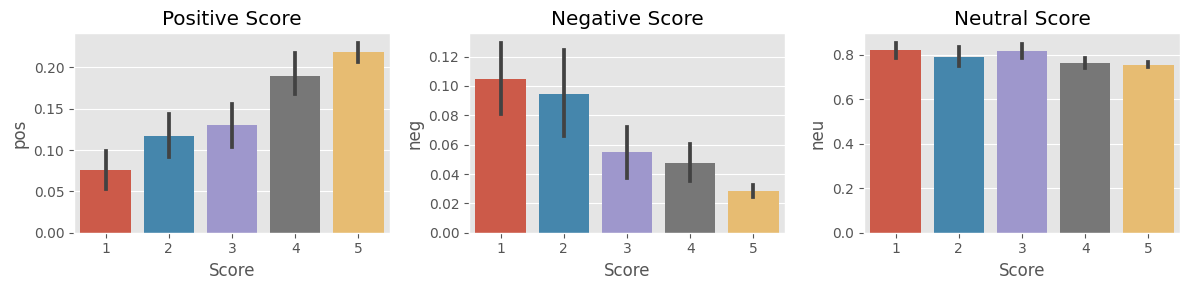

In [46]:
gif, axs = plt.subplots(1,3,figsize=(12,3))
ax = sns.barplot(data=vaders, x='Score', y='pos', ax =axs[0])
ax.set_title("Positive Score")
ax = sns.barplot(data=vaders, x='Score', y='neg', ax =axs[1])
ax.set_title("Negative Score")
ax = sns.barplot(data=vaders, x='Score', y='neu', ax =axs[2])
ax.set_title("Neutral Score")
plt.tight_layout()
plt.show()

# Import Reberta Pretrained Model

In [47]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [48]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [49]:
# Run for the Roberta-Model
def roberta_polarity_scores(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    output = output[0][0].detach().numpy()
    score = softmax(output)
    scores_dict = {
        "rob_neg": score[0],
        "roberta_neu": score[1],
        "roberta_pos": score[2]
    }
    return scores_dict

In [50]:
res = {}
for index,row in tqdm(df.iterrows(), total=len(df)):
    try:
        #Vader Computation
        _id = row['Id']
        text = row['Text']
        vader_score = sia.polarity_scores(text) 
        vader_score_rename={}
        for key, value in vader_score.items():
            vader_score_rename[f"vader_{key}"] = value
        #Roberta Computation
        roberta_score = roberta_polarity_scores(text)
        combined_scores = {**vader_score, **roberta_score}
        res[_id] = combined_scores
    except RuntimeError:
        print(f'Model breaking for ID:{_id}')
# print(res)

  0%|          | 0/500 [00:00<?, ?it/s]

Model breaking for ID:83
Model breaking for ID:187


In [58]:
results = pd.DataFrame(res).T
results = results.reset_index(names=['Id'])
results = results.merge(df, how='left')
results.columns
# results

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'rob_neg', 'roberta_neu',
       'roberta_pos', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


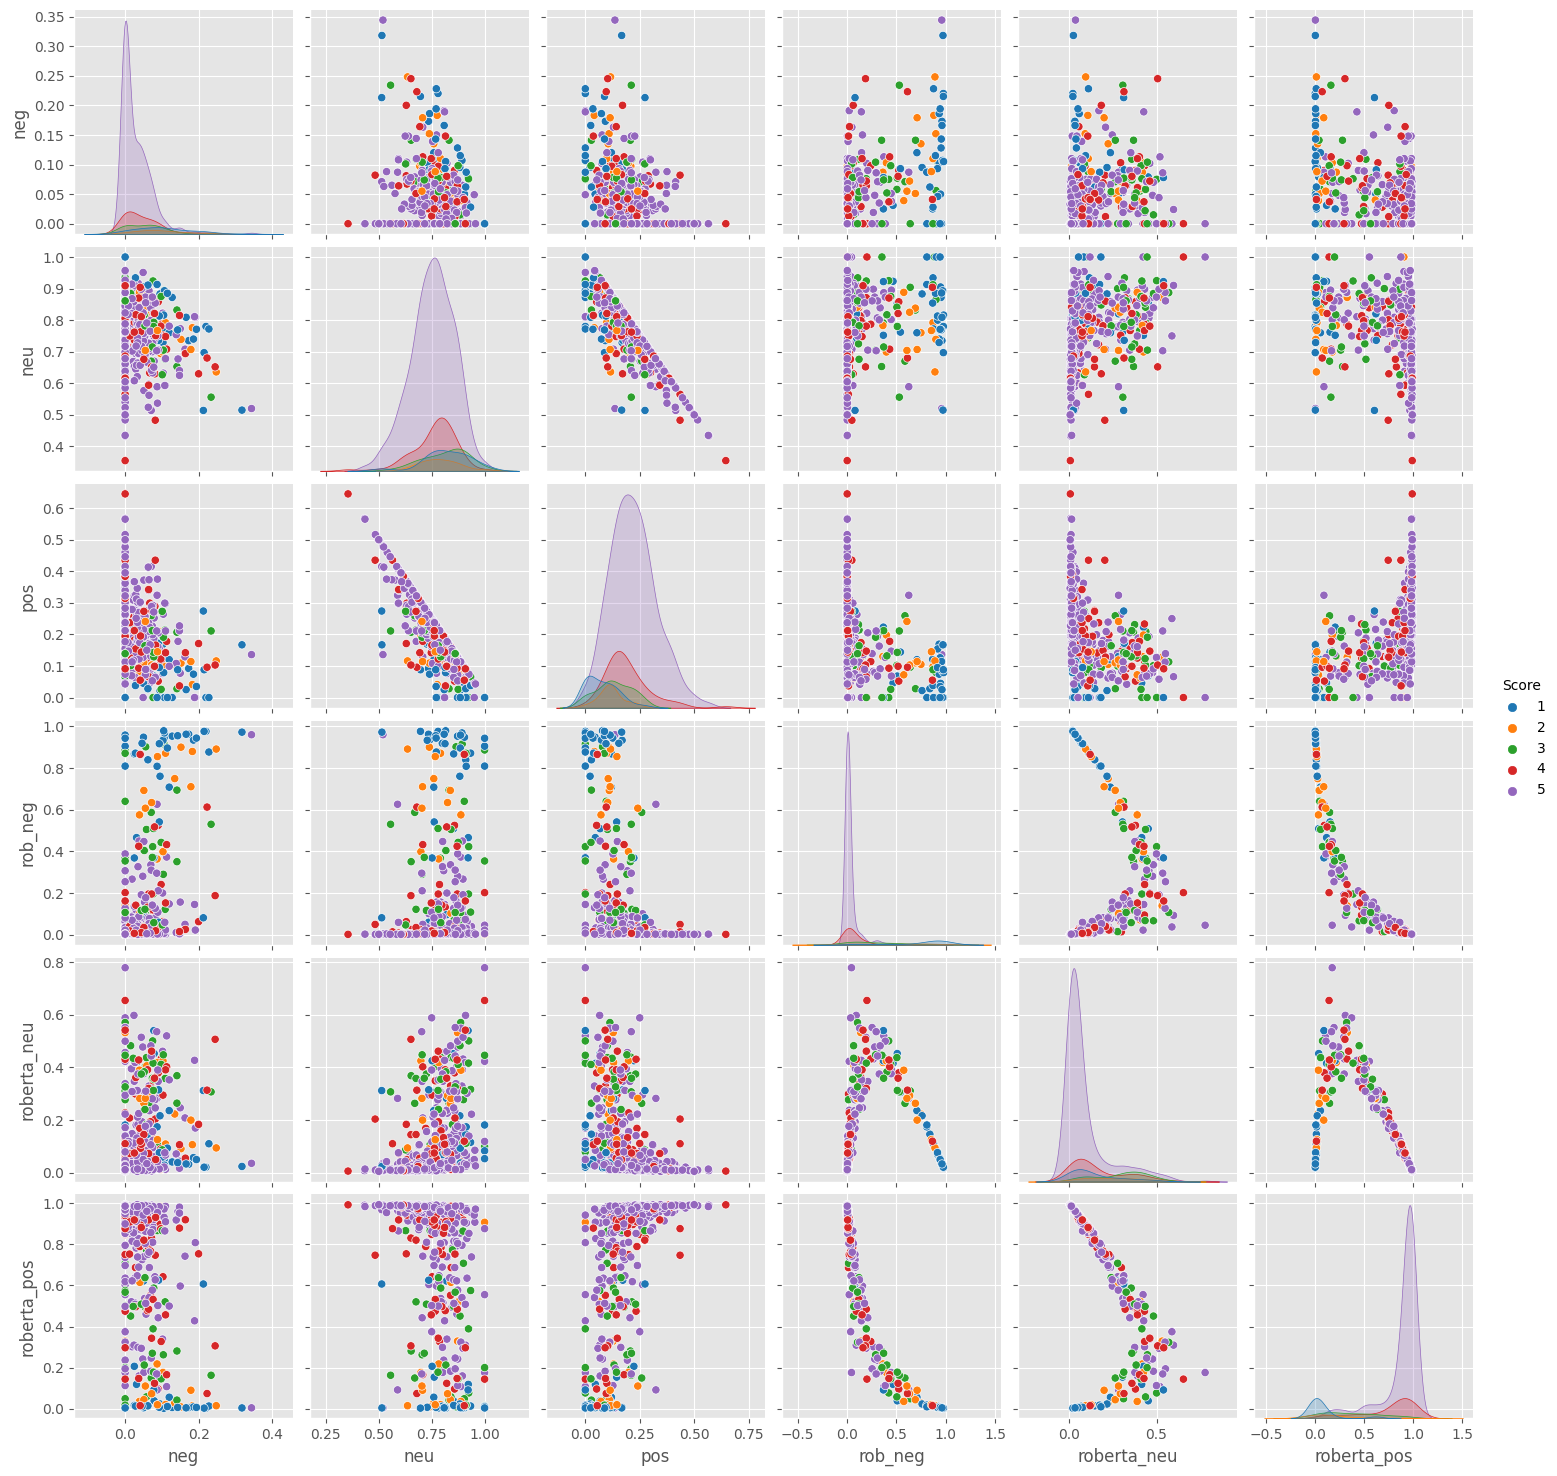

In [61]:
sns.pairplot(data = results, vars=['neg', 'neu', 'pos',
                                   'rob_neg', 'roberta_neu','roberta_pos'], 
                                    hue='Score',
                                    palette='tab10')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


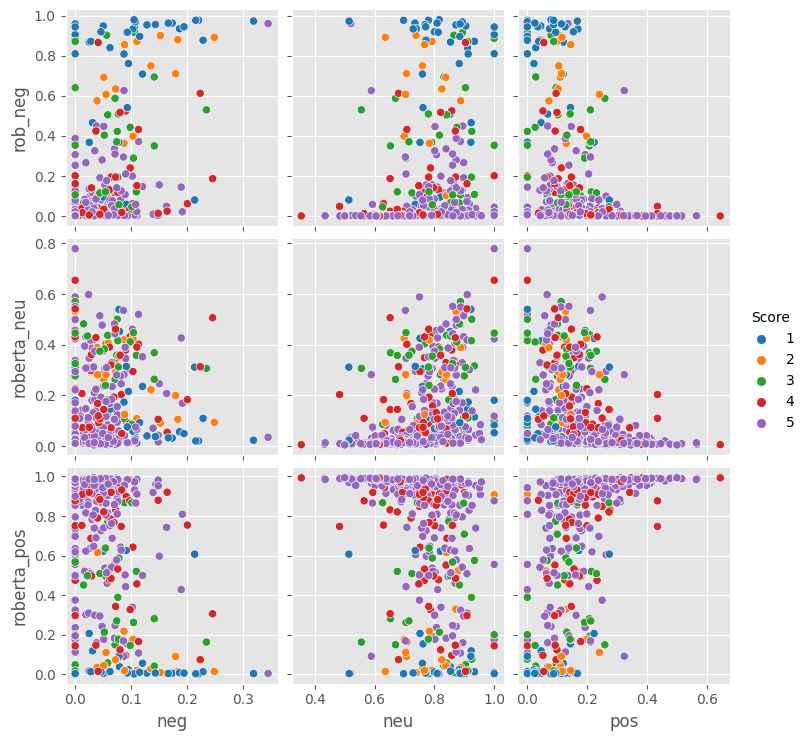

In [62]:
sns.pairplot(data = results, x_vars=['neg', 'neu', 'pos'],
                             y_vars=['rob_neg', 'roberta_neu','roberta_pos'], 
                                    hue='Score',
                                    palette='tab10')

In [ ]:
## Analyse by querying some reviews

## Analyse Roberta Benchmarks by querying 

In [76]:
for i in range(5):
    print(f"Review {i+1}: \n" + results.query("Score == 1").sort_values('roberta_pos', ascending=False)['Text'].values[i]+"\n")

Review 1: 
I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.

Review 2: 
To me, these are nothing like the regular Altoids and are not breath mints. They are pleasant-tasting little candies in a cute convenient tin, and that's as far as it goes. The mintiness is just not strong, and the wintergreens are definitely weaker than the peppermint minis. I'm not a dragon-breath person, but still, one of these mints is too small to have any effect on my breath. Four or five will freshen my breath for a short while - maybe 15 minutes. At this point, I think the Icebreakers Frost mints are the best as sugar free breath mints.

Review 3: 
So we cancelled the order.  It was cancelled without any problem.  That is a positive note...

Review 4: 
Seriously this product was as tasteless as they come. There are much better tasting products out there but at 100 calories its better than a spec

## Analyse Vader Benchmarks by querying 

In [78]:
for i in range(5):
    print(f"Review {i+1}: \n" + results.query("Score == 1").sort_values('pos', ascending=False)['Text'].values[i]+"\n")

Review 1: 
So we cancelled the order.  It was cancelled without any problem.  That is a positive note...

Review 2: 
Seriously this product was as tasteless as they come. There are much better tasting products out there but at 100 calories its better than a special k bar or cookie snack pack. You just have to season it or combine it with something else to share the flavor.

Review 3: 
I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.

Review 4: 
Terrible! Artificial lemon taste, like Pledge Lemon Furniture Polish. Don't do this to yourself. Just use plain flake salt and some fresh grated lemon zest.

Review 5: 
These condiments are overpriced and terrible. The classic is disgustingly sweet. The spiced tastes like a bad spicy marinara sauce from a chain restaurant.



In [79]:
# Using Transformers pipeline

from transformers import pipeline
analyzer = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'NEGATIVE', 'score': 0.9889510273933411}]